In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import PIL
import glob
import matplotlib.pyplot as plt
import time

In [ ]:
def load_images(directory_path):
  image_path_list = []
  for image_path in glob.glob(f"{directory_path}*.jpg"):
    image_path_list.append(image_path)
  image_path_list.sort()
  
  images = []
  for image_path in image_path_list:
    im = PIL.Image.open(image_path).resize((64,64), PIL.Image.BILINEAR)
    im = np.array(im,dtype="f").reshape(4096,3)
    images.append(im)
  
  images_array = np.array(images)
  return images_array

In [ ]:
images = load_images("/content/drive/MyDrive/Homework/afhq_dog/")

In [ ]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [ ]:
#PCA function for 3 color channels
#Returns first k principal components
#Find min principal component to reach 70% PVE
def pca(color_channel,k):
  #Find mean and subtract
  mean = np.mean(color_channel,axis=0)
  color_channel = color_channel - mean

  #Covariance matrix
  cov = np.matmul(color_channel.T,color_channel)

  #Check that cov is symmetric for the usage of np.linalg.eigh
  assert check_symmetric(cov) == True

  #Find eigenvalues and eigenvectors
  eigenvalues, eigenvectors = np.linalg.eigh(cov)

  #Sort them
  eigen_indices = np.argsort(eigenvalues)[::-1]
  eigenvalues = eigenvalues[eigen_indices]
  eigenvectors = eigenvectors[:,eigen_indices]
  
  #Calculate PVE for each eigenvalue
  pve_values = eigenvalues / np.sum(eigenvalues)

  print(pve_values[:k])

  #70% pve
  sum = 0
  indicator = True  
  for index,pve in enumerate(pve_values):
    sum = sum + pve
    if sum >= 0.7 and indicator:
      print(f"{index+1} principal components are needed for 70%")
      indicator = False

    if index == (k-1):
      print(f"PVE for {k} principal components is {sum*100}%")   

  return eigenvectors[:,:k].T,mean

In [ ]:
def normalize(m):
  return (m - m.min()) / (m.max() - m.min())

In [ ]:
red_color_channel,mean_red=pca(images[:,:,0],10)
green_color_channel,mean_green=pca(images[:,:,1],10)
blue_color_channel, mean_blue=pca(images[:,:,2],10)

#normalize
red_color_channel = normalize(red_color_channel).reshape(10,64,64)
green_color_channel = normalize(green_color_channel).reshape(10,64,64)
blue_color_channel = normalize(blue_color_channel).reshape(10,64,64)

[0.21506813 0.13542098 0.07504083 0.05172648 0.0422859  0.02458043
 0.02177032 0.01989657 0.01706975 0.0165585 ]
PVE for 10 principal components is 61.94178946316242%
18 principal components are needed for 70%
[0.20045373 0.13767588 0.07695188 0.05396965 0.04291815 0.02602156
 0.02142609 0.02081249 0.01739321 0.01681112]
PVE for 10 principal components is 61.44337486475706%
19 principal components are needed for 70%
[0.2299456  0.13677008 0.07033232 0.05355895 0.03981729 0.02373058
 0.02098964 0.02075654 0.01668026 0.01629147]
PVE for 10 principal components is 62.88727317005396%
17 principal components are needed for 70%


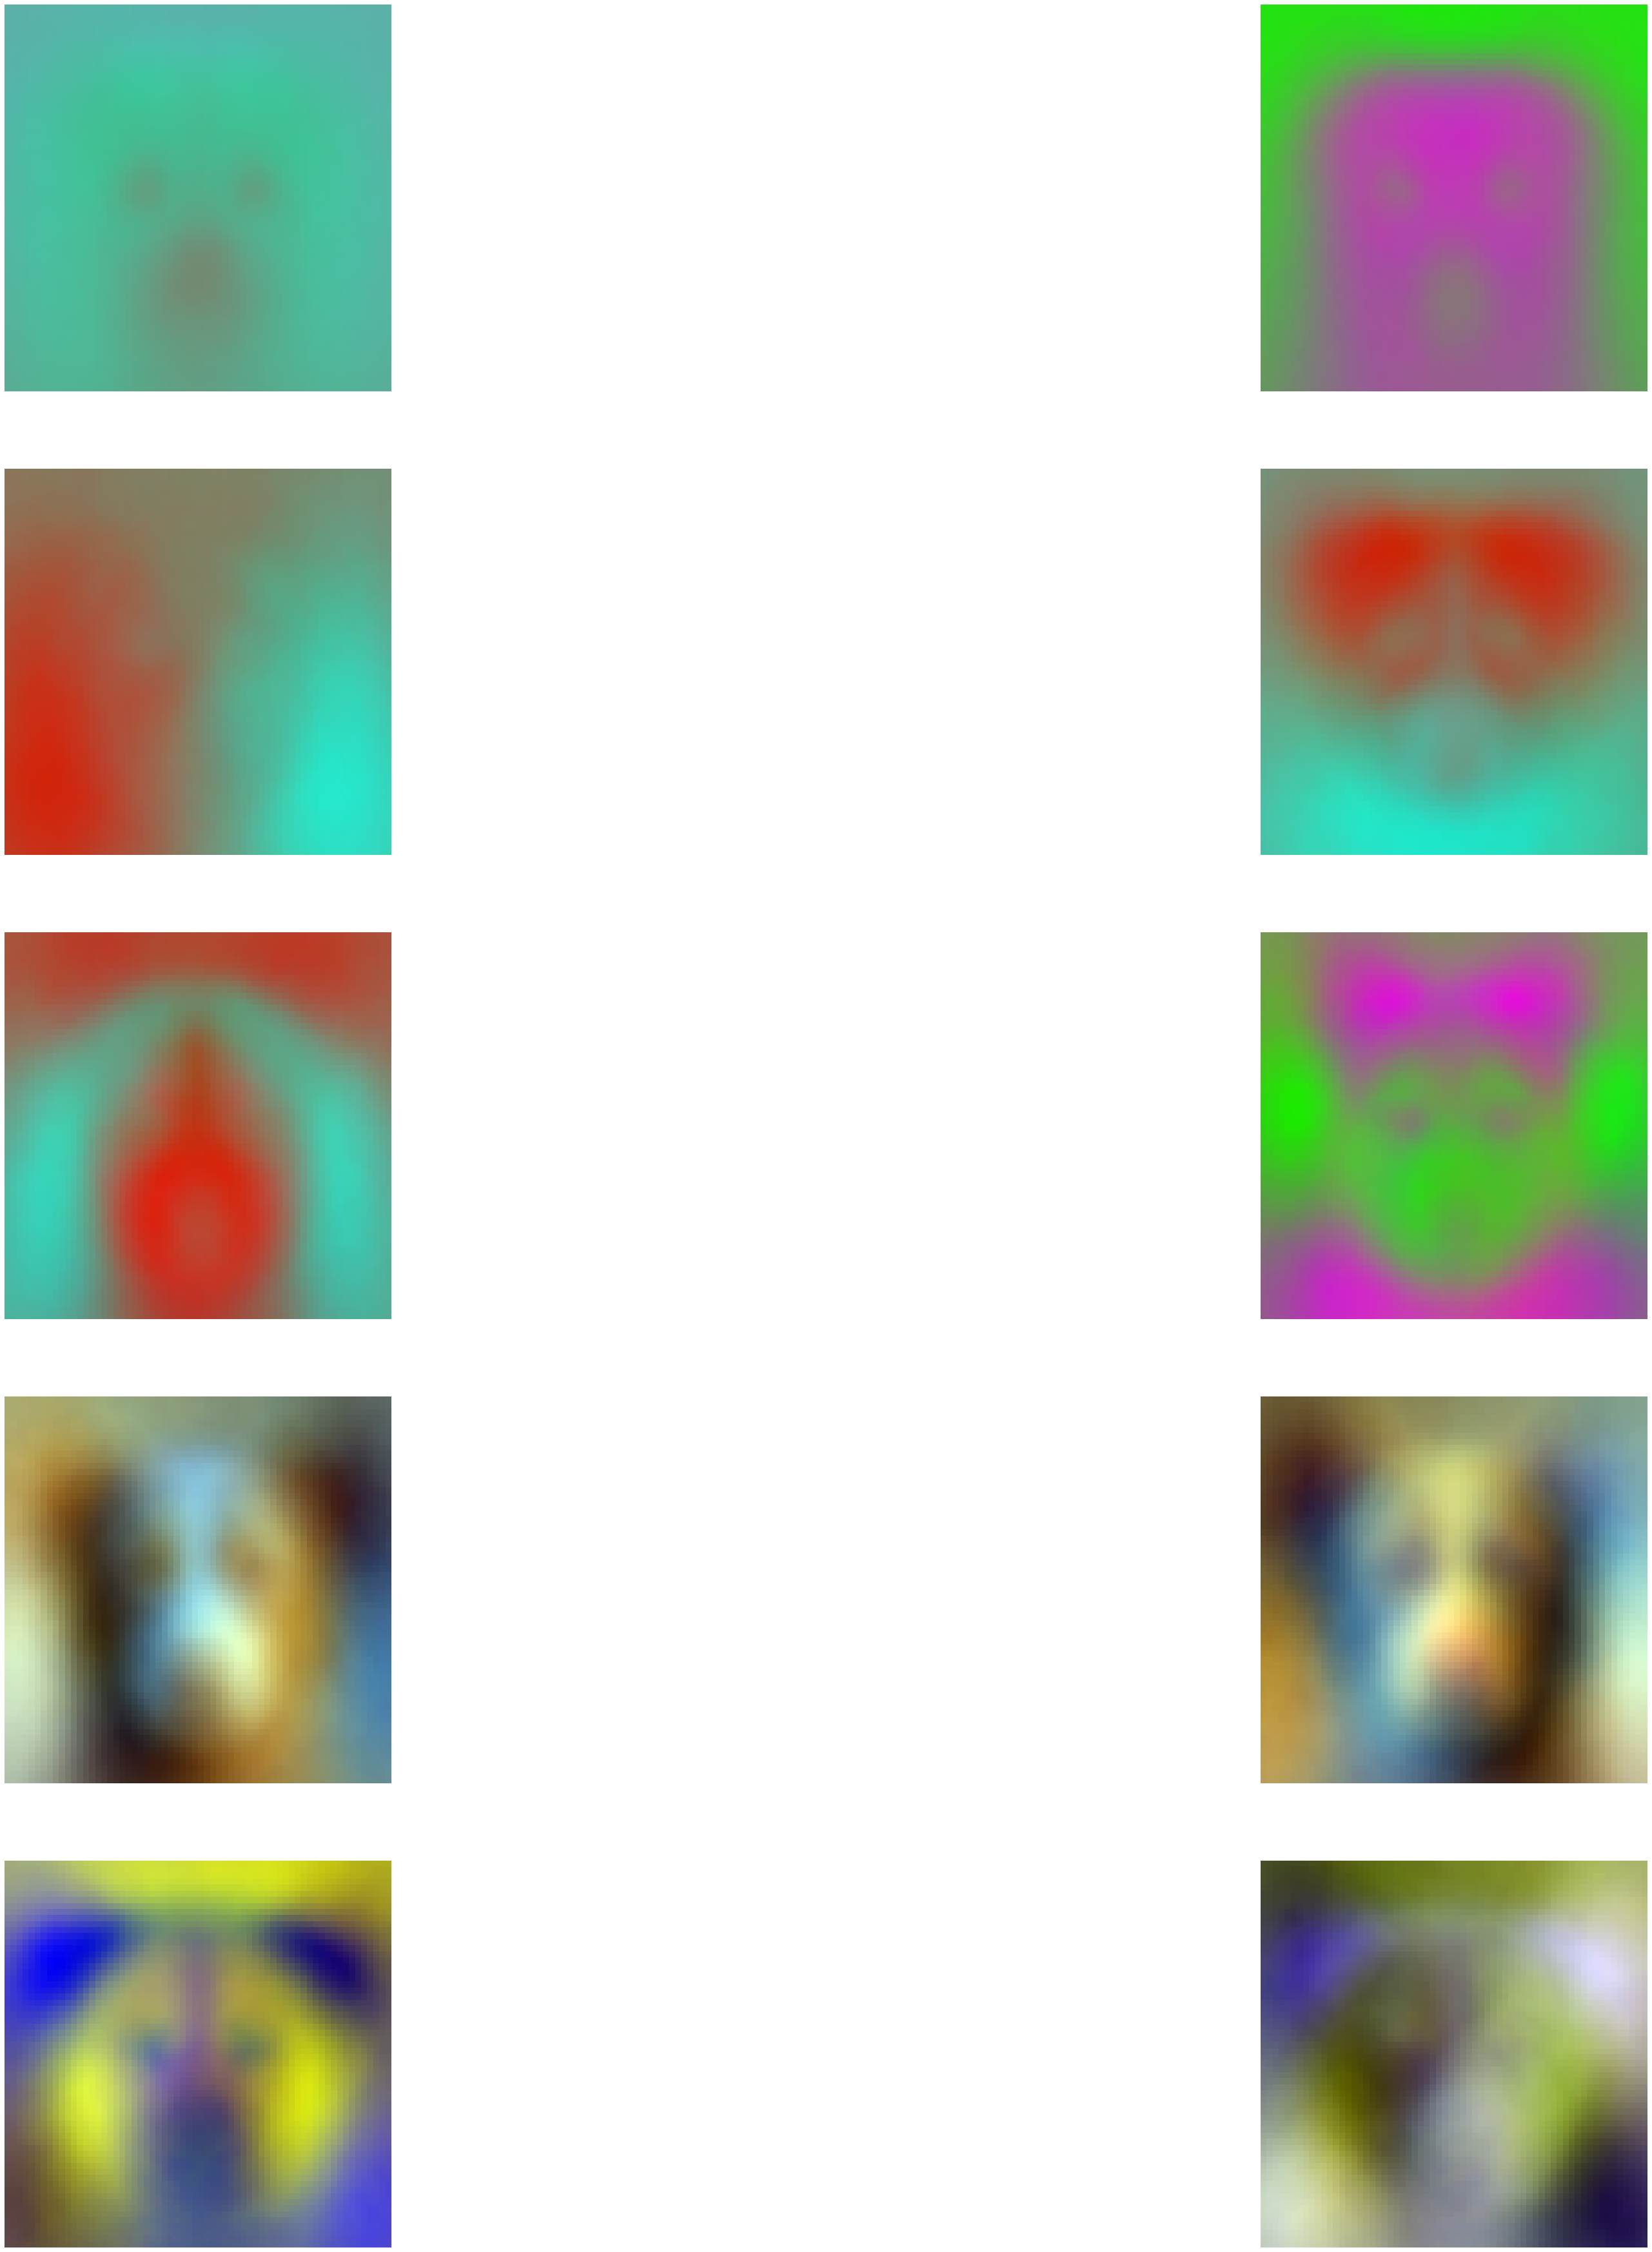

In [ ]:
#Stack different channels
eigen_faces = np.zeros((10,64,64,3))
eigen_faces[:,:,:,0] = red_color_channel
eigen_faces[:,:,:,1] = green_color_channel
eigen_faces[:,:,:,2] = blue_color_channel

#Display eigen faces
fig_faces, axis_faces = plt.subplots(5,2,figsize=(64,64))
image_count = 0
for i in range(5):
  for j in range(2):
    axis_faces[i,j].imshow(eigen_faces[image_count,:,:,:])
    axis_faces[i,j].axis("off")
    image_count = image_count + 1


[0.21506813]
PVE for 1 principal components is 21.506813168525696%
18 principal components are needed for 70%
[0.20045373]
PVE for 1 principal components is 20.04537284374237%
19 principal components are needed for 70%
[0.2299456]
PVE for 1 principal components is 22.99456000328064%
17 principal components are needed for 70%
[0.21506813 0.13542098 0.07504083 0.05172648 0.0422859  0.02458043
 0.02177032 0.01989657 0.01706975 0.0165585  0.01407688 0.0130915
 0.01078741 0.01030046 0.00978004 0.00883312 0.00870801 0.00792801
 0.00767594 0.00724478 0.00687409 0.0061838  0.00583748 0.00562589
 0.00531434 0.0049941  0.00495532 0.00461716 0.00448581 0.00428478
 0.00407312 0.00399861 0.00376597 0.00375309 0.00355127 0.0034897
 0.00335891 0.0031317  0.0030394  0.00289699 0.00288027 0.00274139
 0.00260762 0.00253824 0.00251798 0.00247098 0.00238626 0.00227932
 0.00214841 0.00209672]
18 principal components are needed for 70%
PVE for 50 principal components is 83.07427468243986%
[0.20045373 0.1376

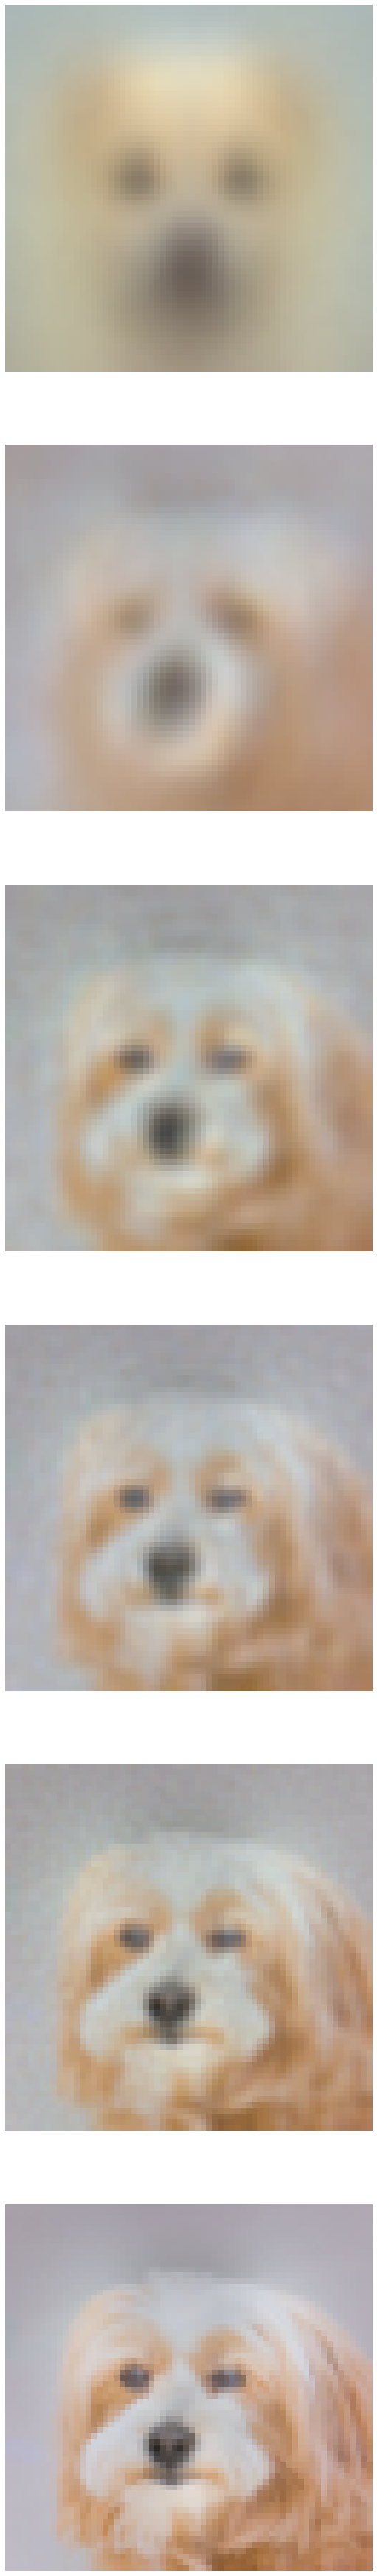

In [ ]:
#Reconstruction
#(data*eigen.T)*eigen + mean
k_values = [1, 50, 250, 500, 1000, 4096]

red_image_data = images[:,:,0] 
green_image_data = images[:,:,1]
blue_image_data = images[:,:,2]

fig, ax = plt.subplots(6,1,figsize=(64,64))
for index,k in enumerate(k_values):
  red_color_channel, mean_red = pca(red_image_data,k)
  green_color_channel, mean_green = pca(green_image_data,k)
  blue_color_channel, mean_blue = pca(blue_image_data,k)  

  red_image_data =red_image_data - mean_red
  green_image_data = green_image_data - mean_green
  blue_image_data = blue_image_data - mean_blue

  reconstructed_image_red = np.matmul(np.matmul(red_image_data,red_color_channel.T),red_color_channel) + mean_red
  reconstructed_image_green = np.matmul(np.matmul(green_image_data,green_color_channel.T),green_color_channel) + mean_green
  reconstructed_image_blue = np.matmul(np.matmul(blue_image_data,blue_color_channel.T),blue_color_channel) + mean_blue

  reconstructed_faces = np.zeros((5239,64,64,3)) 
  reconstructed_faces[:,:,:,0] = normalize(reconstructed_image_red.reshape(5239,64,64))
  reconstructed_faces[:,:,:,1] = normalize(reconstructed_image_green.reshape(5239,64,64))
  reconstructed_faces[:,:,:,2] = normalize(reconstructed_image_blue.reshape(5239,64,64))

  ax[index].imshow(reconstructed_faces[0,:,:,:])
  ax[index].axis("off")  



In [ ]:
#Question2
def load_dataset(path):
  df = pd.read_csv(path)
  #Label unstable as 0, stable as 1.  
  df = df.replace({"label":dict(zip(["unstable","stable"],[0,1]))})
  arr = df.to_numpy()
  n_samples = arr.shape[0]
  #Split x and y
  x_values = arr[:,:-1]
  y_values = arr[:,-1]
  #70% training
  traininig_samples = int(n_samples * 7 / 10)
  x_train = x_values[0:traininig_samples,:]
  y_train = y_values[0:traininig_samples]
  #10% validation
  validation_samples = int(n_samples / 10)
  x_valid = x_values[traininig_samples:(traininig_samples+validation_samples),:]
  y_valid = y_values[traininig_samples:(traininig_samples+validation_samples)]
  #20% test
  x_test = x_values[(traininig_samples+validation_samples):,:]
  y_test = y_values[(traininig_samples+validation_samples):] 
  return x_train,x_valid,x_test,y_train,y_valid,y_test

In [ ]:
x_train,x_valid,x_test,y_train,y_valid,y_test = load_dataset("/content/drive/MyDrive/Homework/dataset.csv")
print(x_train.shape)
print(x_valid.shape)
print(x_test.shape)
print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(42000, 12)
(6000, 12)
(12000, 12)
(42000,)
(6000,)
(12000,)


In [ ]:
#Define sigmoid function
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

In [ ]:
#Normalize the data
min_train_x = x_train.min(axis=0)
max_train_x = x_train.max(axis=0)
print(min_train_x)
print(max_train_x)
def normalize(data):
  data = (data - min_train_x) / (max_train_x - min_train_x)
  return data

[ 0.50079302  0.50014136  0.50014136  0.50014136  1.58258966 -1.99994467
 -1.99994467 -1.99994467  0.0500093   0.05002849  0.05002849  0.05002849]
[ 9.99946947  9.99983656  9.99983656  9.99983656  5.86441796 -0.50002453
 -0.50002453 -0.50002453  0.99993707  0.99998183  0.99998183  0.99998183]


In [ ]:
x_train = normalize(x_train)
print(x_train.min(axis=0))
print(x_train.max(axis=0))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
def init_parameters_gaussian(number_of_weigths,mean,std):
  w = np.random.normal(mean,std,number_of_weigths)
  b = np.random.normal(mean,std,1)
  return w.reshape(number_of_weigths,1),b[0]

def init_parameters_uniform(number_of_weigths):
  w = np.random.uniform(size=number_of_weigths)
  b = np.random.uniform(size=1)
  return w.reshape(number_of_weigths,1),b[0]

def init_parameters_zero(number_of_weigths):
  w = np.zeros(number_of_weigths)
  b = 0
  return w.reshape(number_of_weigths,1),b

In [ ]:
def predict(x,w,b,threshold):
  z = np.matmul(x,w) + b
  y_predict = sigmoid(z)
  y_predict[y_predict < threshold] = 0
  y_predict[y_predict >= threshold] = 1
  y_predict = y_predict.flatten()
  return y_predict

In [ ]:
def validation_accuracy(x_valid,y_valid,w,b,threshold):
  y_predict = predict(x_valid,w,b,threshold)
  err = y_valid - y_predict
  true_labels = np.count_nonzero(err==0)
  return (true_labels / x_valid.shape[0] * 100)

In [ ]:
def confusion_matrix(w_trained,b_trained,threshold,x_test,y_test):
  y_predict = predict(x_test,w_trained,b_trained,threshold)
  #confusion matrix
  y_t = pd.Series(y_test, name='Actual')
  y_pred = pd.Series(y_predict, name='Predicted')
  confusion_matrix = pd.crosstab(y_t, y_pred)
  print(confusion_matrix)

In [ ]:
def gradient_ascent(x_train,y_train,x_valid,y_valid,w,b,batch_size,epoch,learning_rate):
  start = time.time()
  N = x_train.shape[0]
  iteration_per_epoch = int(N/batch_size)
  valid_accuracy =[]
  #Shuffle the data
  sample_order = np.random.permutation(N)
  x_train_data = x_train[sample_order,:]
  y_train_data = y_train[sample_order]
  for i in range(epoch):
    batch_start_index = 0
    batch_end_index = batch_size

    for j in range(iteration_per_epoch):
      batch_data_x = x_train_data[batch_start_index:batch_end_index,:]
      batch_data_y = y_train_data[batch_start_index:batch_end_index].reshape(-1,1)

      #calculate related gradients
      z = np.matmul(batch_data_x,w) + b
      y_predict = sigmoid(z)
      err = batch_data_y - y_predict      
      dw = np.matmul(batch_data_x.T,err)
      db = np.sum(err)

      #update parameters
      w = w + learning_rate * dw
      b = b + learning_rate * db

      #update batch indexes
      batch_start_index = batch_end_index
      batch_end_index = batch_end_index + batch_size
      if batch_end_index > N:
        batch_end_index = N 
    
    #validation accuracy at each epoch
    threshold = 0.5    
    valid_accuracy.append(validation_accuracy(x_valid,y_valid,w,b,threshold))

  end = time.time()
  print(f"Total elapsed time for batch size {batch_size} is {end-start} s. Final validation accuracy after {epoch}th epoch is {valid_accuracy[-1]}.")
  return w,b,valid_accuracy


In [ ]:
x_valid = normalize(x_valid)

In [ ]:
w_gaussian,b_gaussian = init_parameters_gaussian(x_train.shape[1],0,1)
w_uniform,b_uniform = init_parameters_uniform(x_train.shape[1])
w_zeros,b_zero = init_parameters_zero(x_train.shape[1])

In [ ]:
w_trained_m,b_trained_m,valid_accuracy_m=gradient_ascent(x_train,y_train,x_valid,y_valid,w_gaussian,b_gaussian,64,100,1e-3)
w_trained_s,b_trained_s,valid_accuracy_s=gradient_ascent(x_train,y_train,x_valid,y_valid,w_gaussian,b_gaussian,1,100,1e-3)
w_trained_f,b_trained_f,valid_accuracy_f=gradient_ascent(x_train,y_train,x_valid,y_valid,w_gaussian,b_gaussian,x_train.shape[0],100,1e-3)

Total elapsed time for batch size 64 is 3.1716437339782715 s. Final validation accuracy after 100th epoch is 82.3.
Total elapsed time for batch size 1 is 90.46781349182129 s. Final validation accuracy after 100th epoch is 82.19999999999999.
Total elapsed time for batch size 42000 is 0.33124327659606934 s. Final validation accuracy after 100th epoch is 64.36666666666667.


In [ ]:
#Confusion matrix for the best model
confusion_matrix(w_trained_m,b_trained_m,0.5,x_valid,y_valid)

Predicted   0.0   1.0
Actual               
0.0        3420   426
1.0         636  1518


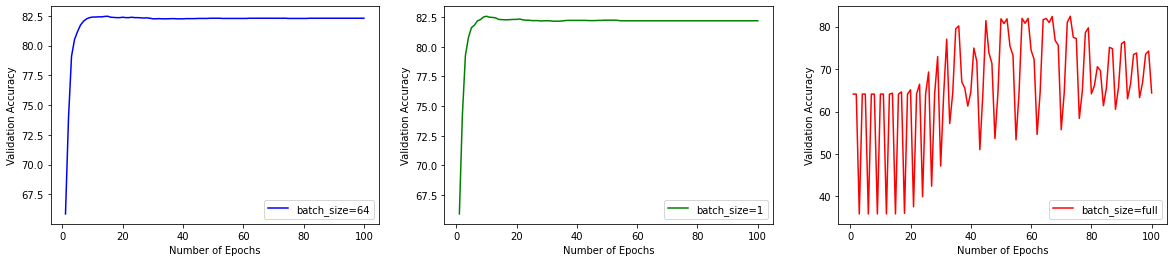

In [ ]:
fig,ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot([x for x in range(1,101)],valid_accuracy_m,color="blue",label="batch_size=64")
ax[0].set_xlabel("Number of Epochs")
ax[0].set_ylabel("Validation Accuracy")
ax[0].legend(loc="best")
ax[1].plot([x for x in range(1,101)],valid_accuracy_s,color="green",label="batch_size=1")
ax[1].set_xlabel("Number of Epochs")
ax[1].set_ylabel("Validation Accuracy")
ax[1].legend(loc="best")
ax[2].plot([x for x in range(1,101)],valid_accuracy_f,color="red",label="batch_size=full")
ax[2].set_xlabel("Number of Epochs")
ax[2].set_ylabel("Validation Accuracy")
ax[2].legend(loc="best")
plt.show()

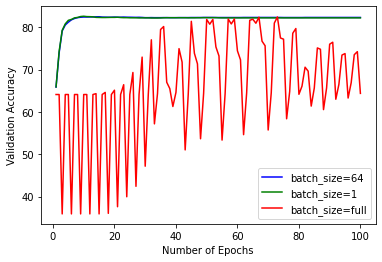

In [ ]:
plt.plot([x for x in range(1,101)],valid_accuracy_m,color="blue",label="batch_size=64")
plt.plot([x for x in range(1,101)],valid_accuracy_s,color="green",label="batch_size=1")
plt.plot([x for x in range(1,101)],valid_accuracy_f,color="red",label="batch_size=full")
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
w_trained_m_u,b_trained_m_u,valid_accuracy_m_u=gradient_ascent(x_train,y_train,x_valid,y_valid,w_uniform,b_uniform,64,100,1e-3)
w_trained_m_z,b_trained_m_z,valid_accuracy_m_z=gradient_ascent(x_train,y_train,x_valid,y_valid,w_zeros,b_zero,64,100,1e-3)

Total elapsed time for batch size 64 is 2.7128257751464844 s. Final validation accuracy after 100th epoch is 82.15.
Total elapsed time for batch size 64 is 2.696054458618164 s. Final validation accuracy after 100th epoch is 82.28333333333333.


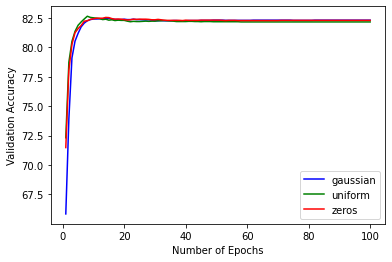

In [ ]:
plt.plot([x for x in range(1,101)],valid_accuracy_m,color="blue",label="gaussian")
plt.plot([x for x in range(1,101)],valid_accuracy_m_u,color="green",label="uniform")
plt.plot([x for x in range(1,101)],valid_accuracy_m_z,color="red",label="zeros")
plt.xlabel("Number of Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
#Confusion matrix for the best model
confusion_matrix(w_trained_m,b_trained_m,0.5,x_valid,y_valid)

Predicted   0.0   1.0
Actual               
0.0        3420   426
1.0         636  1518


Total elapsed time for batch size 64 is 2.7804980278015137 s. Final validation accuracy after 100th epoch is 81.58333333333333.
Total elapsed time for batch size 64 is 2.672161102294922 s. Final validation accuracy after 100th epoch is 82.25.
Total elapsed time for batch size 64 is 2.650407314300537 s. Final validation accuracy after 100th epoch is 82.46666666666667.
Total elapsed time for batch size 64 is 2.633030652999878 s. Final validation accuracy after 100th epoch is 65.9.


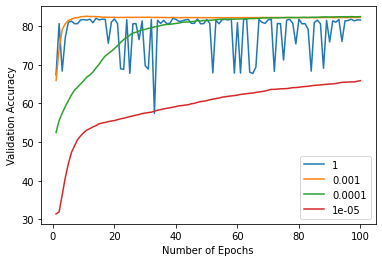

In [ ]:
learning_rates = [1,1e-3,1e-4,1e-5]
for l_r in learning_rates:
  w_trained_m,b_trained_m,valid_accuracy_m=gradient_ascent(x_train,y_train,x_valid,y_valid,w_gaussian,b_gaussian,64,100,l_r)
  plt.plot([x for x in range(1,101)],valid_accuracy_m,label=f"{l_r}")

plt.xlabel("Number of Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
x_test = normalize(x_test)

In [ ]:
w_trained_m,b_trained_m,valid_accuracy_m=gradient_ascent(x_train,y_train,x_valid,y_valid,w_gaussian,b_gaussian,64,100,1e-4)

Total elapsed time for batch size 64 is 2.6694324016571045 s. Final validation accuracy after 100th epoch is 82.56666666666666.


In [ ]:
confusion_matrix(w_trained_m,b_trained_m,0.5,x_valid,y_valid)

Predicted   0.0   1.0
Actual               
0.0        3480   366
1.0         680  1474


In [ ]:
confusion_matrix(w_trained_m,b_trained_m,0.5,x_test,y_test)

Predicted   0.0   1.0
Actual               
0.0        6837   814
1.0        1442  2907


In [ ]:
#class 0 is positive
def evaluation(y,pred):
  N = len(y)
  diff = y - pred
  sum = y + pred
  true_counts = np.count_nonzero(diff==0)
  t_neg = np.count_nonzero(sum==2)
  t_pos = np.count_nonzero(sum==0)
  f_neg = np.count_nonzero(diff==-1)
  f_pos = np.count_nonzero(diff==1)

  accuracy = true_counts / N
  precision = t_pos / (t_pos + f_pos)
  recall = t_pos / (t_pos + f_neg)
  f1_score = (2 * precision * recall) / (precision + recall)
  f2_score = (5 * precision * recall)/(4 * precision+recall)
  f05_score = (1.25 * precision * recall)/( 0.25 * precision + recall)
  f_pos_rate = f_pos / (f_pos+t_neg)

  return accuracy,precision,recall,f1_score,f2_score,f05_score,f_pos_rate

In [ ]:
accuracy,precision,recall,f1_score,f2_score,f05_score,f_pos_rate = evaluation(y_test,predict(x_test,w_trained_m,b_trained_m,0.5))

In [ ]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 score: {f1_score}")
print(f"F2 score: {f2_score}")
print(f"F0.5 score: {f05_score}")
print(f"False Positive Rate: {f_pos_rate}")

Accuracy: 0.812
Precision: 0.8258243749245078
Recall: 0.8936086786041041
F1 score: 0.8583804143126177
F2 score: 0.8791759895069826
F0.5 score: 0.8385458826992421
False Positive Rate: 0.3315704759714877
